Số quan sát: 24
Train samples: 16
Test samples : 5


C:\Users\hienn\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Huấn luyện LSTM hoàn tất
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step

===== ĐÁNH GIÁ MÔ HÌNH LSTM =====
MAE = 22,942,903,104 USD | RMSE = 26,613,378,935 USD | R² = 0.5210


,Year,GDP_Thực_tế,GDP_Dự_đoán
0,2019,3.343650e+11,3.361822e+11
1,2020,3.466160e+11,3.717926e+11
2,2021,3.664750e+11,4.003852e+11
3,2022,4.134450e+11,4.279706e+11
4,2023,4.338580e+11,4.731429e+11


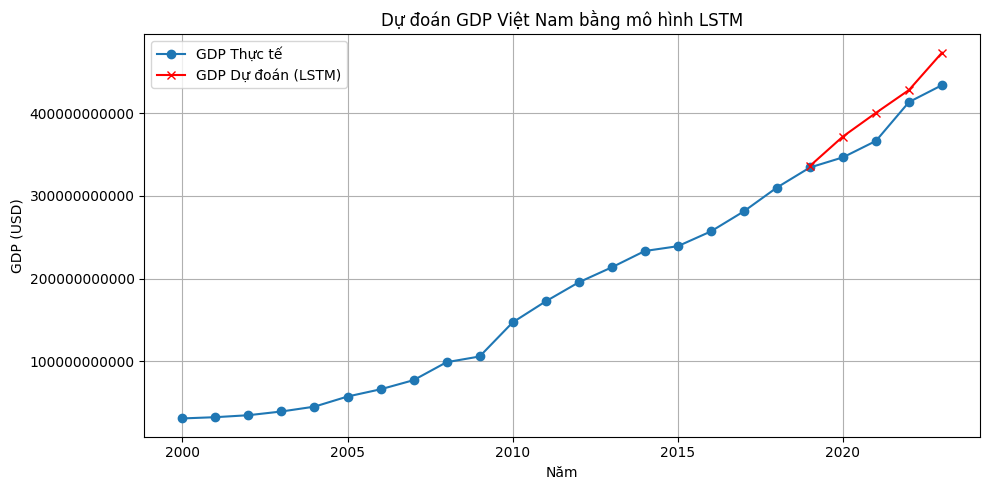

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# 1. ĐỌC DỮ LIỆU
df = pd.read_csv("macro_vietnam_processed.csv")

# Lấy chuỗi GDP theo năm
gdp = df["GDP"].values.reshape(-1, 1)
years = df["Year"].values

print("Số quan sát:", len(gdp))

# 2. CHUẨN HÓA DỮ LIỆU
scaler = MinMaxScaler()
gdp_scaled = scaler.fit_transform(gdp)

# 3. TẠO DỮ LIỆU DẠNG CHUỖI (SLIDING WINDOW)
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 3  # dùng 3 năm trước để dự đoán năm tiếp theo

X, y = create_sequences(gdp_scaled, window_size)

# 4. CHIA TRAIN / TEST (GIẤU 5 NĂM CUỐI)
n_test = 5

X_train = X[:-n_test]
X_test  = X[-n_test:]

y_train = y[:-n_test]
y_test  = y[-n_test:]

years_test = years[window_size + len(X_train):]

print("Train samples:", X_train.shape[0])
print("Test samples :", X_test.shape[0])

# 5. XÂY DỰNG MÔ HÌNH LSTM
model = Sequential([
    LSTM(32, activation="tanh", input_shape=(window_size, 1)),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss="mse"
)

# 6. HUẤN LUYỆN MÔ HÌNH
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=4,
    verbose=0
)

print("Huấn luyện LSTM hoàn tất")

# 7. DỰ ĐOÁN & ĐÁNH GIÁ
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_real = scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
r2 = r2_score(y_test_real, y_pred)

print("\n===== ĐÁNH GIÁ MÔ HÌNH LSTM =====")
print(
    f"MAE = {mae:,.0f} USD | "
    f"RMSE = {rmse:,.0f} USD | "
    f"R² = {r2:.4f}"
)

# 8. BẢNG SO SÁNH THỰC TẾ & DỰ ĐOÁN
result_df = pd.DataFrame({
    "Year": years_test,
    "GDP_Thực_tế": y_test_real.flatten(),
    "GDP_Dự_đoán": y_pred.flatten()
})

display(result_df)

# 9. BIỂU ĐỒ SO SÁNH
plt.figure(figsize=(10,5))

plt.plot(years, gdp, label="GDP Thực tế", marker="o")
plt.plot(years_test, y_pred, label="GDP Dự đoán (LSTM)", marker="x", color="red")

plt.title("Dự đoán GDP Việt Nam bằng mô hình LSTM")
plt.xlabel("Năm")
plt.ylabel("GDP (USD)")
plt.legend()
plt.grid(True)
plt.ticklabel_format(style="plain", axis="y")

plt.tight_layout()
plt.show()


➡️ Thực hiện dự đoán GDP cho 10 năm tiếp theo

===== KẾT QUẢ DỰ ĐOÁN GDP TƯƠNG LAI =====


,Year,GDP_Dự_đoán
0,2024,5.117829e+11
1,2025,5.908279e+11
2,2026,6.810980e+11
3,2027,7.890500e+11
4,2028,9.038092e+11
5,2029,1.017524e+12
6,2030,1.120368e+12
7,2031,1.203880e+12
8,2032,1.265350e+12
9,2033,1.307098e+12


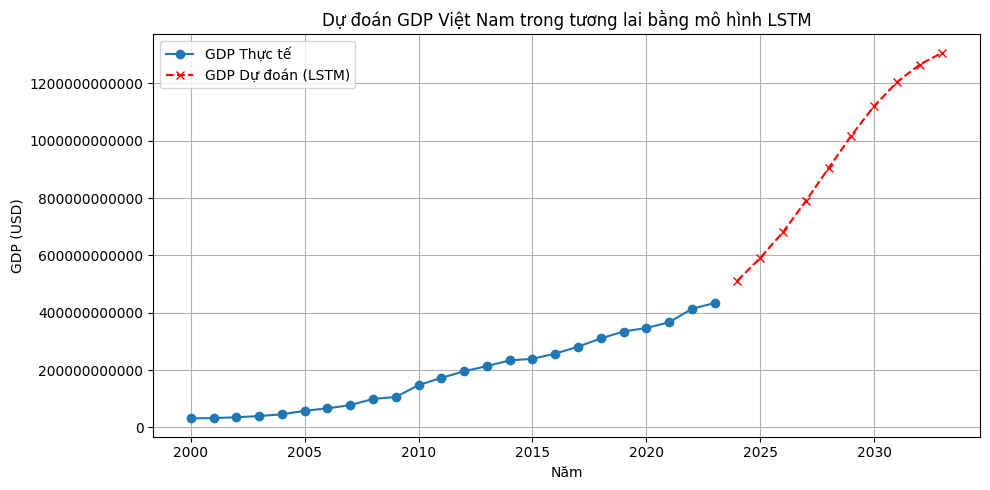


===== NHẬN XÉT DỰ BÁO =====
Trong giai đoạn 2024 – 2033, mô hình LSTM dự báo GDP Việt Nam có xu hướng tăng trưởng với mức thay đổi khoảng 155.40%. Kết quả phản ánh xu hướng tăng trưởng dựa trên động thái lịch sử của GDP, tuy nhiên cần được xem xét thận trọng do dữ liệu huấn luyện còn hạn chế.


In [2]:
# DEMO DỰ ĐOÁN GDP CÁC NĂM TƯƠNG LAI BẰNG LSTM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. NHẬP THAM SỐ DỰ ĐOÁN
# Số năm muốn dự đoán trong tương lai
n_future = int(input("Nhập số năm muốn dự đoán GDP trong tương lai: "))

print(f"\n➡️ Thực hiện dự đoán GDP cho {n_future} năm tiếp theo")

# 2. CHUẨN BỊ DỮ LIỆU ĐẦU VÀO BAN ĐẦU
# Lấy window_size năm cuối cùng trong dữ liệu gốc
last_sequence = gdp_scaled[-window_size:].copy()

future_predictions_scaled = []
future_predictions = []

current_input = last_sequence.reshape(1, window_size, 1)

# 3. DỰ ĐOÁN LẦN LƯỢT CÁC NĂM TƯƠNG LAI
for i in range(n_future):
    next_pred_scaled = model.predict(current_input, verbose=0)
    future_predictions_scaled.append(next_pred_scaled[0, 0])

    # Cập nhật input cho lần dự đoán tiếp theo
    current_input = np.append(
        current_input[:, 1:, :],
        next_pred_scaled.reshape(1, 1, 1),
        axis=1
    )

# Chuyển ngược về giá trị GDP thực
future_predictions = scaler.inverse_transform(
    np.array(future_predictions_scaled).reshape(-1, 1)
).flatten()

# 4. TẠO BẢNG KẾT QUẢ DỰ ĐOÁN
last_year = int(df["Year"].max())
future_years = [last_year + i + 1 for i in range(n_future)]

forecast_df = pd.DataFrame({
    "Year": future_years,
    "GDP_Dự_đoán": future_predictions
})

print("\n===== KẾT QUẢ DỰ ĐOÁN GDP TƯƠNG LAI =====")
display(forecast_df)

# 5. BIỂU ĐỒ GDP QUÁ KHỨ & DỰ ĐOÁN TƯƠNG LAI
plt.figure(figsize=(10,5))

plt.plot(df["Year"], gdp, label="GDP Thực tế", marker="o")
plt.plot(future_years, future_predictions, label="GDP Dự đoán (LSTM)", 
         marker="x", linestyle="--", color="red")

plt.title("Dự đoán GDP Việt Nam trong tương lai bằng mô hình LSTM")
plt.xlabel("Năm")
plt.ylabel("GDP (USD)")
plt.legend()
plt.grid(True)
plt.ticklabel_format(style="plain", axis="y")

plt.tight_layout()
plt.show()

# 6. NHẬN XÉT TỰ ĐỘNG BẰNG LỜI
growth_rate = (future_predictions[-1] - future_predictions[0]) / future_predictions[0] * 100

print("\n===== NHẬN XÉT DỰ BÁO =====")
print(
    f"Trong giai đoạn {future_years[0]} – {future_years[-1]}, "
    f"mô hình LSTM dự báo GDP Việt Nam có xu hướng "
    f"{'tăng trưởng' if growth_rate > 0 else 'giảm'} "
    f"với mức thay đổi khoảng {abs(growth_rate):.2f}%. "
    "Kết quả phản ánh xu hướng tăng trưởng dựa trên động thái lịch sử của GDP, "
    "tuy nhiên cần được xem xét thận trọng do dữ liệu huấn luyện còn hạn chế."
)
